** Imports**

In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import math

In [2]:
from costs import *
from models import *
from helpers import * 
from evaluation import *
from split_data import *
from split_features import *

## Data loading
** Load the training data into feature matrix, class labels, and record ids**

We write our own `load_csv_data` function to import csv data, which gives us prediction column, feature matrix and each record ID.

In [37]:
from proj1_helpers import *
DATA_TRAIN_PATH = 'data/train.csv' # TODO: download train data and supply path here 
y, tx, ids = load_csv_data(DATA_TRAIN_PATH, sub_sample=False)

### Split the dataset into trainset and testset in order to test accuracy

In [38]:
x_train, y_train, x_test, y_test = split_data(tx, y, 0.5)

In [39]:
x_train.shape

(125000, 30)

In [40]:
tx = x_train
y = y_train

## Data Preprocessing

### Split into 6 distinct datasets

According to our exploration, we can distinct 3 different dataset based on number of jets each experiments contains. Then each of them can be split again into 2 different datasets based on whether they have a measurable mass or not.

In [41]:
jet0, jet1, jet23, y0, y1, y23 = split_on_jets(y, tx)
jet0_nomass, jet0, y0_nomass, y0 = split_on_mass(y0, jet0)
jet1_nomass, jet1, y1_nomass, y1 = split_on_mass(y1, jet1)
jet23_nomass, jet23, y23_nomass, y23 = split_on_mass(y23, jet23)

### Only keep the features without NaN in each subset

In [42]:
jet0_nomass, selected_jet0_nomass = select_features_without_nan(jet0_nomass)
jet0, selected_jet0 = select_features_without_nan(jet0)
jet1_nomass, selected_jet1_nomass = select_features_without_nan(jet1_nomass)
jet1, selected_jet1 = select_features_without_nan(jet1)
jet23_nomass, selected_jet23_nomass = select_features_without_nan(jet23_nomass)
jet23, selected_jet23 = select_features_without_nan(jet23)


### Outliers

<function matplotlib.pyplot.show>

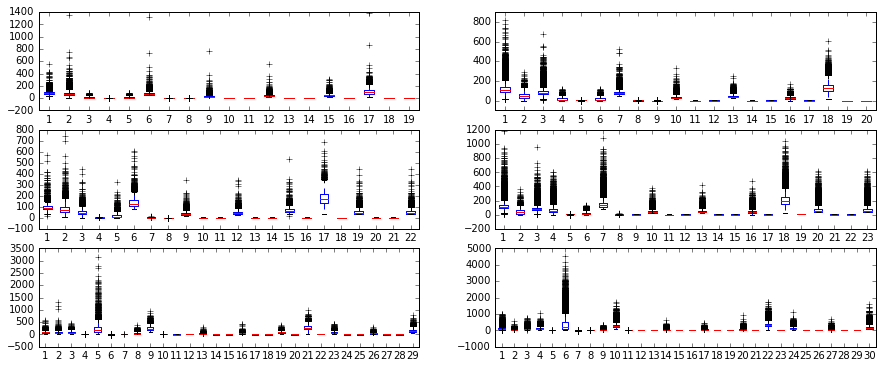

In [43]:
plt.figure(figsize=(15, 6)) 
plt.subplot(321)
plt.boxplot(jet0_nomass)
plt.subplot(322)
plt.boxplot(jet0)
plt.subplot(323)
plt.boxplot(jet1_nomass)
plt.subplot(324)
plt.boxplot(jet1)
plt.subplot(325)
plt.boxplot(jet23_nomass)
plt.subplot(326)
plt.boxplot(jet23)
plt.show

In [44]:
jet0_nomass_outlier = jet0_nomass[np.where(jet0_nomass[:,1] < 1200)]
jet0_outlier = jet0[np.where(jet0[:,3] < 1200)]

In [45]:
y0_nomass = y0_nomass[np.where(jet0_nomass[:,1] < 1200)]
y0 = y0[np.where(jet0[:,3] < 1200)]
jet0_nomass = jet0_nomass_outlier
jet0 = jet0_outlier


In [46]:
print(y0.shape)
print(jet0.shape)

(36905,)
(36905, 20)


### Standardization of values
We use [feature scaling](https://en.wikipedia.org/wiki/Feature_scaling) method to standardize our feature matrix, i.e. to rescale tx down to [0, 1], so as to avoid complicated computation caused by large numbers.

In [47]:
tx = standardize(tx)
std_jet0_nomass, min0_nomass, range0_nomass = standardize(jet0_nomass)
std_jet0, min0, range0 = standardize(jet0)
std_jet1_nomass, min1_nomass, range1_nomass = standardize(jet1_nomass)
std_jet1, min1, range1 = standardize(jet1)
std_jet23_nomass, min23_nomass, range23_nomass = standardize(jet23_nomass)
std_jet23, min23, range23 = standardize(jet23)

## Machine Learning

### Logistic Regression

Choose intial parameters

In [48]:
n_iters = 2000
gamma = 0.000003

Train with logistic regression

In [49]:
print("w0_nomass")
loss0_nomass, w0_nomass = logistic_regression(y0_nomass, std_jet0_nomass, gamma, n_iters)
print("w0")
loss0, w0 = logistic_regression(y0, std_jet0, gamma, n_iters)

print("w1_nomass")
loss1_nomass, w1_nomass = logistic_regression(y1_nomass, std_jet1_nomass, gamma, n_iters)
print("w1")
loss1_nomass, w1 = logistic_regression(y1, std_jet1, gamma, n_iters)

print("w23_nomass")
loss23_nomass, w23_nomass = logistic_regression(y23_nomass, std_jet23_nomass, gamma, n_iters)
print("w23")
loss23, w23 = logistic_regression(y23, std_jet23, gamma, n_iters)


w0_nomass
Current iteration=0, the loss=9131.52095669672, gradient=0.07199645233254495
Current iteration=500, the loss=9132.263741514671, gradient=0.07183760724837934
Current iteration=1000, the loss=9133.004917502234, gradient=0.07167912307496209
Current iteration=1500, the loss=9133.744488010714, gradient=0.07152099901489456
Final loss=9134.480982045005
w0
Current iteration=0, the loss=25580.59669856478, gradient=0.4285116731090396
Current iteration=500, the loss=25586.054650421862, gradient=0.4273564863818285
Current iteration=1000, the loss=25591.50441695633, gradient=0.42620445345062014
Current iteration=1500, the loss=25596.945983470934, gradient=0.4250555658073734
Final loss=25602.368477009077
w1_nomass
Current iteration=0, the loss=2594.449896835875, gradient=0.14979325143484012
Current iteration=500, the loss=2594.9305499323123, gradient=0.1493118205428527
Current iteration=1000, the loss=2595.409738816964, gradient=0.1488319689427218
Current iteration=1500, the loss=2595.8874

## Accuracy testing against virtual test_set

In [50]:
testset = x_test

y_pred = apply_right_model(testset, \
                  selected_jet0_nomass, selected_jet0, selected_jet1_nomass, selected_jet1, \
                  selected_jet23_nomass, selected_jet23, \
                  min0_nomass, min0, min1_nomass, min1, min23_nomass, min23, \
                  range0_nomass, range0, range1_nomass, range1, range23_nomass, range23, \
                  w0_nomass, w0, w1_nomass, w1, w23_nomass, w23)


In [57]:
y_test[np.where(y_test == 0)] = -1

In [55]:
y_pred

array([ 1,  1,  1, ...,  1, -1, -1])

In [58]:
test_accuracy(y_test, y_pred)

0.50956

## Output prediction to Kaggle

In [14]:
test_x = np.genfromtxt('data/test.csv', delimiter=',', skip_header=1)

In [15]:
ids = test_x[:, 0]
testset = test_x[:, 2:] # remove id and prediction columns

y_pred = apply_right_model(testset, \
                  selected_jet0_nomass, selected_jet0, selected_jet1_nomass, selected_jet1, \
                  selected_jet23_nomass, selected_jet23, \
                  min0_nomass, min0, min1_nomass, min1, min23_nomass, min23, \
                  range0_nomass, range0, range1_nomass, range1, range23_nomass, range23, \
                  w0_nomass, w0, w1_nomass, w1, w23_nomass, w23)


In [17]:
y_pred.shape

(568238,)

In [18]:
create_csv_submission(ids, y_pred, 'data/split_data2.csv')

## Feature Engineering
TODO

## Prediction

**Generate predictions and save ouput in csv format for submission**